In [2]:
import py_wave_runup
from examples.evaluate_returnperiods import load_scenario_data, load_timeseries_data
import sys
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import py_wave_runup
import seaborn as sns


In [30]:
#Run this if you want to compare different scenarios and return periods
#=========================================================
#Wave Dataset
#=========================================================
Tp_returnvals = pd.read_csv('data\Tp_return_vals.csv')
Tp=np.reshape(Tp_returnvals.drop(columns='return period').values, (15,))
Hs_returnvals = pd.read_csv('data\Hs_return_vals.csv')
Hs=np.reshape(Hs_returnvals.drop(columns='return period').values, (15,))
returnperiod = [5]*3 + [10] * 3 + [20]*3 + [50]*3 + [100]*3
MHHW = 5.24 #ft
setup = 1 #ft


#=========================================================
#Slope Info Dataset
#=========================================================
scenario = 'data\Adamson_M_Z_scenarios.csv'
df = load_scenario_data(scenario, Hs, Tp, returnperiod)

In [3]:
# #Run this if you want to run time series
# df = load_timeseries_data('data\Hs_ts.csv','data\Tp_ts.csv', dtoe=2, slope=1/10)
# df.bsand = 1/100

In [31]:
df_stock = df.copy(deep=True)
df_stock = df_stock.loc[(df_stock.scenario == 1) | (df_stock.scenario==2)]
df = df.loc[(df.scenario==3) | (df.scenario==4)]
print(df.dtoeSWL.unique())

blen = py_wave_runup.models.Blenkinsopp2022(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)
euro = py_wave_runup.models.EurOtop2018(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)
poate = py_wave_runup.models.Poate2016(Hs=df.hs,beta=df.beta,bsand=df.bsand,bberm=df.bberm,dtoeSWL=df.dtoeSWL,Tp=df.tp,spectral_wave_period=True,h=10)
stock = py_wave_runup.models.Stockdon2006(Hs=df_stock.hs,beta=df_stock.beta,bsand=df_stock.bsand,bberm=df_stock.bberm,dtoeSWL=df_stock.dtoeSWL,Tp=df_stock.tp,spectral_wave_period=True,h=10)

df_taw = df.copy(deep=True)
df_poate = df.copy(deep=True)

df_stock['r2'] = stock.R2*3.28
df_stock['TWL'] = stock.R2*3.28 + MHHW + setup
df_stock['method'] = ['Stockdon'] * len(df_stock.hs)


df['r2'] = (blen.R2_eq21)*3.28
df_taw['r2'] = (euro.R2(gamma_f=0.70))*3.28
df_poate['r2'] = (poate.R2())*3.28


df['TWL'] = blen.R2_eq21*3.28 + MHHW + setup
df_taw['TWL'] = (euro.R2(gamma_f=0.70))*3.28 + MHHW + setup
df_poate['TWL'] = (poate.R2())*3.28 + MHHW + setup


df['method'] = ['Blenkinsopp 2022'] * len(df.hs)
df_poate['method'] = ['Poate 2016'] * len(df.hs)
df_taw['method'] = ['TAW'] * len(df.hs)


df_full = pd.concat([df, df_taw, df_poate, df_stock])
df_full['hs'] = df_full['hs']*3.28
df_full['htoe'] = blen.Htoe*3.28

[0.3030303  0.60606061]


['Blenkinsopp 2022' 'TAW' 'Poate 2016']


[Text(0, 0, 'Blenkinsopp 2022'), Text(1, 0, 'TAW'), Text(2, 0, 'Poate 2016')]

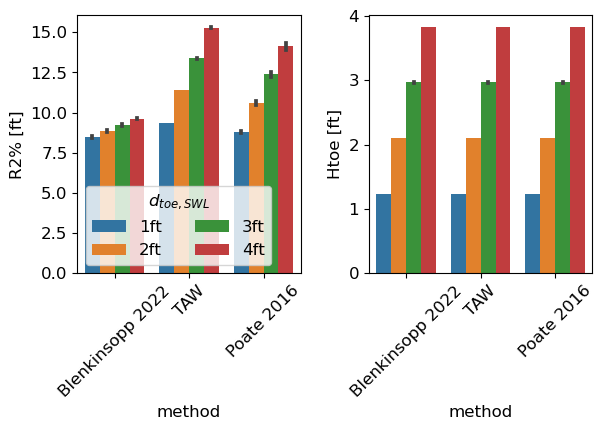

In [28]:
fig, ax = pl.subplots(1,2)
pl.tight_layout()
fig.set_size_inches(6,3)
a = sns.barplot(x='method',y='TWL', data=df_full[(df_full.transect==i+1)&(df_full.returnperiod==10)&(df_full.dtoeSWL<300)],hue='dtoeSWL',ax=ax[0])
legend_labels, _= ax[0].get_legend_handles_labels()
ax[0].legend(legend_labels,['1ft','2ft','3ft','4ft'],title=r'$d_{toe,SWL}$',ncol=2, loc=3)
ax[0].set_ylabel('R2% [ft]')
ax[0].set_xticklabels(df_full.method.unique(),rotation = 45)

a = sns.barplot(x='method',y='htoe', data=df_full[(df_full.transect==i+1)&(df_full.returnperiod==10)&(df_full.dtoeSWL<300)],hue='dtoeSWL',ax=ax[1])
ax[1].legend_.remove()
ax[1].set_ylabel('Htoe [ft]')
ax[1].set_xticklabels(df_full.method.unique(),rotation = 45)

    

In [ ]:
#Run this for continuous data plot
# fig, ax = pl.subplots(1,1)
# a = sns.scatterplot(x='hs',y='r2',hue='method',data=df_full)
# pl.legend(loc='upper left')
# ax.set_xlabel('Hs [ft]')
# ax.set_ylabel('R2% [ft]')
# ax.set_xlim((3,8))
# ax.set_ylim((0,10))
# pl.savefig('hsvsr2vsmethod.png')

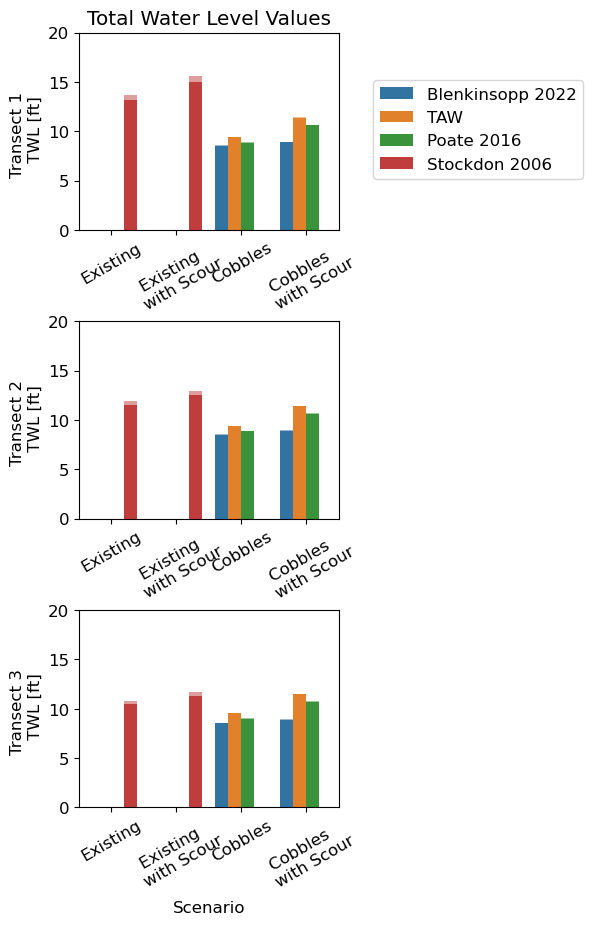

In [32]:
# #Run this for scenario plotting
rp =10
fig, ax = pl.subplots(3,1)
pl.tight_layout()
fig.set_size_inches((3,9))
for i in range(3):
    a = sns.barplot(x='scenario',y='TWL', data=df_full[(df_full.transect==i+1)&(df_full.returnperiod==10)],hue='method',ax = ax[i],errorbar=None)
    b = sns.barplot(x='scenario',y='TWL',alpha=0.5, data=df_full[(df_full.transect==i+1)&(df_full.returnperiod==20)],hue='method',ax = ax[i],errorbar=None)
    plotlegend = False
    if (i==0):
        plotlegend=True
    if plotlegend:
        ax[i].legend(bbox_to_anchor=(1.1,0.8),labels=['Blenkinsopp 2022','TAW', 'Poate 2016', 'Stockdon 2006'])
    if not plotlegend:
        a.legend_.remove()
    ax[i].set_ylabel('Transect {0} \n TWL [ft]'.format(i+1))
    if i < 2:
        ax[i].set_xlabel('')

    ax[i].set_xticklabels(['Existing', 'Existing \n with Scour', 'Cobbles', 'Cobbles \n  with Scour'], rotation = 30)

    ax[0].set_title('Total Water Level Values')
    ax[i].set_ylim((0,20))
    ax[2].set_xlabel('Scenario')
pl.savefig('scenarios.png')


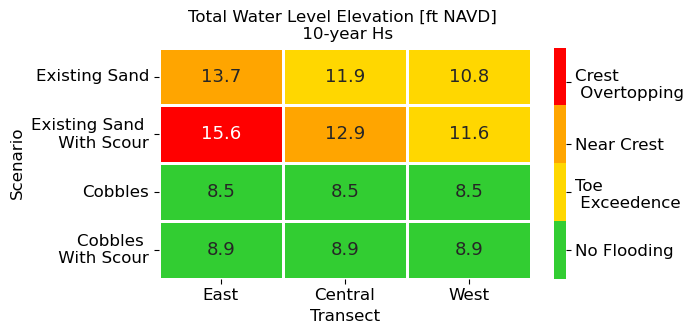

In [54]:
#Plot only Blenkinsopp and Stockdon
import matplotlib as mpl
pl.rcParams.update({'font.size': 12})
df_full = df_full[(df_full.method=='Stockdon')|(df_full.method=='Blenkinsopp 2022')&(df_full.returnperiod==10)]
vals = df_full.pivot_table(columns = 'transect',index='scenario',values = 'TWL')
cmap = mpl.colors.ListedColormap(["limegreen", "gold",'orange',"red"])
norm = mpl.colors.BoundaryNorm([8,10,12,15,20], cmap.N) 
#make font size bigger
#include grid lines 
fig, ax = pl.subplots(1,1)
fig.set_size_inches((6,3))
aa=sns.heatmap(vals, annot=True, fmt=".1f",annot_kws={"size": 13}, vmin=15,vmax=25,cmap=cmap,norm=norm,linewidths=2,linecolor='w')
ax.set_ylabel('Scenario',fontsize=12)
ax.set_yticklabels(['Existing Sand', 'Existing Sand \n With Scour', 'Cobbles', 'Cobbles \n With Scour'], rotation = 0)
ax.set_xlabel('Transect',fontsize=12)
ax.set_xticklabels(['East', 'Central','West']) #Transect 1 is east, 2 is central, 3 is west
#ax.xaxis.tick_top() # x axis on top
#ax.xaxis.set_label_position('top')
ax.set_title('Total Water Level Elevation [ft NAVD] \n 10-year Hs', fontsize=12)# put label on bottom
cbar = aa.collections[0].colorbar
cbar.set_ticks([9,11,13,17])
cbar.set_ticklabels(['No Flooding', 'Toe \n Exceedence', 'Near Crest', 'Crest \n Overtopping'], fontsize=12)
pl.savefig('ComparativeMatrix.png',dpi=100)





[67.80784377220917, 70.10086425075299, 57.30438009045792, 58.16094071056253, 46.355976447580446, 47.985622616158196]


<AxesSubplot:xlabel='Scenario', ylabel='Percent Reduction'>

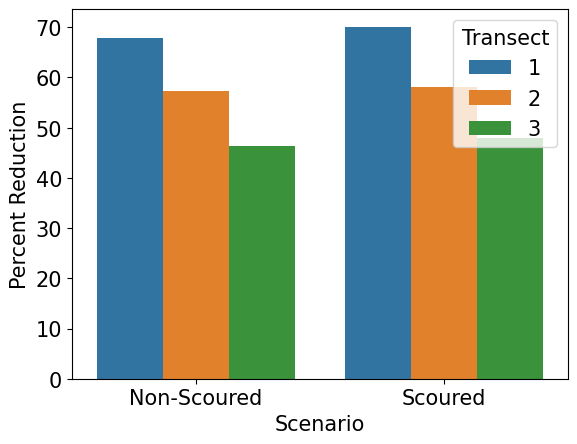

In [34]:
#Percent reduction charts
transect = []
plesslist = []
scenario = []

for i in range(1,4):
    r2_old = df_full[(df_full.method=='Stockdon')&(df_full.scenario==1)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    r2_new = df_full[(df_full.method=='Blenkinsopp 2022')&(df_full.scenario==3)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    pless = (r2_old-r2_new)/r2_old*100
    plesslist.append(pless)
    scenario.append('Non-Scoured')
    transect.append(i)
    
    r2_old = df_full[(df_full.method=='Stockdon')&(df_full.scenario==2)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    r2_new = df_full[(df_full.method=='Blenkinsopp 2022')&(df_full.scenario==4)&(df_full.transect==i)&(df_full.returnperiod==10)].r2.mean()
    pless_scour = (r2_old-r2_new)/r2_old*100
    plesslist.append(pless_scour)
    scenario.append('Scoured')
    transect.append(i)

percent_reduct_df = pd.DataFrame({'Transect':transect, 'Percent Reduction':plesslist, 'Scenario':scenario})

print(plesslist)

fig, ax = pl.subplots(1,1)
sns.barplot(y='Percent Reduction',x='Scenario',hue='Transect',data=percent_reduct_df)
